In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [5]:
# reflect an existing database into a new model

# reflect the tables
# Reflect Database into ORM classes
Base = automap_base()
Base.prepare(engine, reflect=True)


In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Station = Base.classes.station
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
results = session.query(Station).limit(5).all()
for st in results:
    print('---------------------')
    print(f"ID: {st.id}")
    print(f"Station: {st.station}")
    print(f"Name: {st.name}")
    print(f"Latitude: {st.latitude}")
    print(f"Longitude: {st.longitude}")
    print(f"Elevation: {st.elevation}")

---------------------
ID: 1
Station: USC00519397
Name: WAIKIKI 717.2, HI US
Latitude: 21.2716
Longitude: -157.8168
Elevation: 3.0
---------------------
ID: 2
Station: USC00513117
Name: KANEOHE 838.1, HI US
Latitude: 21.4234
Longitude: -157.8015
Elevation: 14.6
---------------------
ID: 3
Station: USC00514830
Name: KUALOA RANCH HEADQUARTERS 886.9, HI US
Latitude: 21.5213
Longitude: -157.8374
Elevation: 7.0
---------------------
ID: 4
Station: USC00517948
Name: PEARL CITY, HI US
Latitude: 21.3934
Longitude: -157.9751
Elevation: 11.9
---------------------
ID: 5
Station: USC00518838
Name: UPPER WAHIAWA 874.3, HI US
Latitude: 21.4992
Longitude: -158.0111
Elevation: 306.6


In [10]:
m_results = session.query(Measurement).limit(5).all()
for st in m_results:
    print('---------------------')
    print(f"ID: {st.id}")
    print(f"Station: {st.station}")
    print(f"Date: {st.date}")
    print(f"PRCP: {st.prcp}")
    print(f"TOBS: {st.tobs}")

---------------------
ID: 1
Station: USC00519397
Date: 2010-01-01
PRCP: 0.08
TOBS: 65.0
---------------------
ID: 2
Station: USC00519397
Date: 2010-01-02
PRCP: 0.0
TOBS: 63.0
---------------------
ID: 3
Station: USC00519397
Date: 2010-01-03
PRCP: 0.0
TOBS: 74.0
---------------------
ID: 4
Station: USC00519397
Date: 2010-01-04
PRCP: 0.0
TOBS: 76.0
---------------------
ID: 5
Station: USC00519397
Date: 2010-01-06
PRCP: None
TOBS: 73.0


# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
results =session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]

recent_date = dt.datetime.strptime(results , '%Y-%m-%d')
print(recent_date)

2017-08-23 00:00:00


2016-08-23 00:00:00


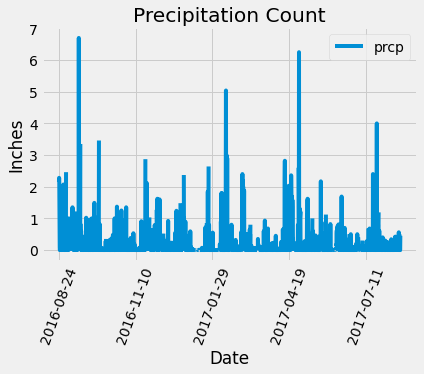

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

one_year = dt.timedelta(days=365)
new_date = recent_date - one_year
print(new_date)

# Perform a query to retrieve the data and precipitation scores
recentyear_data =session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= new_date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column

recentyear_df = pd.DataFrame(recentyear_data)
#recentyear_df.head()

# Set index to date
recentyear_df.set_index('date', inplace=True)

# Sort the dataframe by date
recentyear_df.sort_values(by=['date'], inplace= True)
#recentyear_df.head()

recentyear_df.plot()
plt.legend(loc='upper right')
plt.xlabel('Date')
plt.ylabel('Inches')
plt.title('Precipitation Count')
plt.xticks(rotation=70)
plt.show()


In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
recentyear_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(Station).distinct(Station.station).count()
print(station_count)

9


In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station)\
.order_by(func.count(Measurement.station).desc()).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# most active station id
active_station_id = results[0][0]

In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

statistics = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs), func.count(Measurement.tobs)).filter(Measurement.station == active_station_id)
print(f"Temp details for most active station: {active_station_id}")
print(f"Min Temp: {statistics[0][0]}")
print(f"Max Temp: {statistics[0][1]}")
print(f"Avg Temp: {round(statistics[0][2],2)}")


Temp details for most active station: USC00519281
Min Temp: 54.0
Max Temp: 85.0
Avg Temp: 71.66


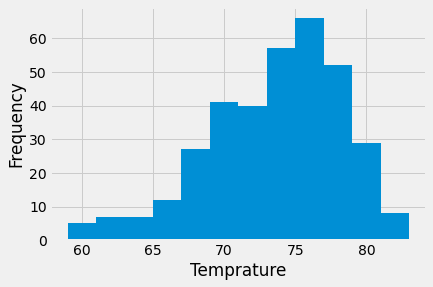

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
recentyear_temp_data =session.query( Measurement.tobs).filter(Measurement.date >= new_date).filter(Measurement.station == active_station_id).all()
# Save the query results as a Pandas DataFrame and set the index to the date column

recentyear_temp_df = pd.DataFrame(recentyear_temp_data)


# Sort the dataframe by date
recentyear_temp_df.hist(bins=12)
plt.xlabel('Temprature')
plt.ylabel('Frequency')
plt.title('')
plt.show()


# Close session

In [19]:
# Close Session
session.close()